# Conditioning of a three-dimensional aluvial binary model (Maules Creek)

In this example we have pretrained a GAN on the aluvial Maules Creek training image.  
We will use the methodology of Yeh et. al. to condition GAN simulations to a 1D well.

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from conditioner.conditioner import Conditioner, Unconditional
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import scipy.ndimage.filters as filters 
from sklearn.metrics import accuracy_score
%matplotlib inline

## Load Pre-trained Networks

We have pretrained a WGAN-LP model with a latent vector size of 20 on the Maules Creek dataset.  
The following code is defines model architecture.

In [2]:
def get_activation():
    return nn.ReLU()

class GeneratorSub(nn.Module):
    def __init__(self):
        super(GeneratorSub, self).__init__()
        self.network = self.build_network()
        
    def build_network(self, activation=get_activation):
        blocks = []
        blocks += [nn.ConvTranspose3d(20, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512), activation()]
        blocks += [nn.ConvTranspose3d(512, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256), activation()]
        blocks += [nn.ConvTranspose3d(256, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128), activation()]
        blocks += [nn.ConvTranspose3d(128, 64, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(64), activation()]
        blocks += [nn.Conv3d(64, 1, kernel_size=3, stride=1, padding=1), nn.Tanh()]
        return nn.Sequential(*blocks)
    
    def forward(self, z):
        return self.network(z)
    
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = GeneratorSub()
        
    def forward(self, z):
        return self.module(z)
    
class DiscriminatorSub(nn.Module):
    def __init__(self):
        super(DiscriminatorSub, self).__init__()
        self.network = self.build_network()
        
    def build_network(self, activation=get_activation):
        blocks = []
        blocks += [nn.Conv3d(1, 32, kernel_size=5, stride=2, padding=1), activation()]
        blocks += [nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1), activation()]
        blocks += [nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1), activation()]
        blocks += [nn.Conv3d(128, 1, kernel_size=3, stride=2, padding=1), activation()]
        return nn.Sequential(*blocks)
    
    def forward(self, x):
        dec = self.network(x) 
        dec = dec.view(-1, 2**4)
        return dec
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.module = DiscriminatorSub()
        
    def forward(self, x):
        return self.module(x)

In [4]:
latent_size = 20

generator = Generator()
generator.load_state_dict(torch.load("./checkpoints/alluvial_model/generator_maules_creek_64_mult_1639.pth"))


discriminator = Discriminator()
discriminator.load_state_dict(torch.load("./checkpoints/alluvial_model/discriminator_maules_creek_64_mult_1639.pth"))

## Determine Latent Size

We determine first the size of the latent vector required to simulate images the size of the our conditioning data.

We can choose to do this analytically if the network architecture is known, or else empirically by scaling the latent vector.

In [6]:
import tifffile
uncond = Unconditional(3, generator, latent_size, "normal", use_cuda=True)
x = 1
for i in range(1, 10):
    samples = uncond.create_unconditional_simulations(1, [2, i*2, i*2])
    if samples is not None:
        print "Imsize: ", i, "Uncoditional Simulation Size: ", samples.shape

Imsize:  1 Uncoditional Simulation Size:  (1, 1, 32, 32, 32)
Imsize:  2 Uncoditional Simulation Size:  (1, 1, 32, 64, 64)
Imsize:  3 Uncoditional Simulation Size:  (1, 1, 32, 96, 96)
Imsize:  4 Uncoditional Simulation Size:  (1, 1, 32, 128, 128)
Imsize:  5 Uncoditional Simulation Size:  (1, 1, 32, 160, 160)
Imsize:  6 Uncoditional Simulation Size:  (1, 1, 32, 192, 192)
Imsize:  7 Uncoditional Simulation Size:  (1, 1, 32, 224, 224)
Imsize:  8 Uncoditional Simulation Size:  (1, 1, 32, 256, 256)
Imsize:  9 Uncoditional Simulation Size:  (1, 1, 32, 288, 288)


## Determine Trim Size

Due to border artifacts resulting from transposed convolution, it is necessary to trim outer regions when these occur.  
We determine this by sampling unconditional simulations and creating a mean and standard deviation plot. 

In [7]:
samples = []
for i in tqdm_notebook(range(128)):
    samples.append(uncond.create_unconditional_simulations(1, [2, 4*2, 4*2]).reshape(1, 32, 128, 128))

HBox(children=(IntProgress(value=0, max=128), HTML(value=u'')))

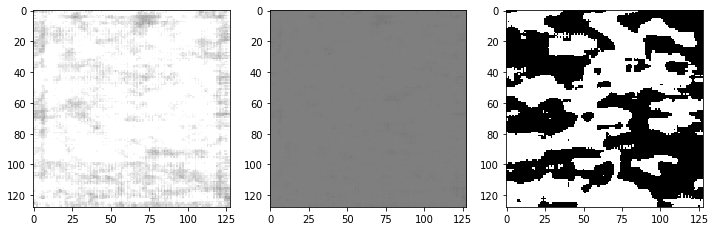

In [8]:
samples_arr = np.where(np.concatenate(samples, 0)*0.5+0.5 >= 0.5, 1.0, 0.0)
mean = np.mean(samples_arr, axis=0)
std = np.std(samples_arr, axis=0)
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(mean[16], cmap="gray", vmin=0.0, vmax=0.5)
ax[1].imshow(std[16], cmap="gray", vmin = 0.0, vmax=1.0)
ax[2].imshow(samples_arr[0, 16], cmap="gray")

We find a few artifacts on the borders, and some repeated patterns due to the transposed convolution, but generally this is quite a good result.

## Load Conditioning Data and set mask

In this case we condition on a 1-dimensional part of the binary training image.

In [9]:
data = np.loadtxt("./datasets/alluvial_model/Maules_Creek_3D.SGEMS", skiprows=3)
data = data.reshape(80, 200, 340)

This is just a simple mask of a single well in the middle, but more complex things can be done as well.  
Points, lines, or volumes could serve as conditioning regions.

In [10]:
mask = np.zeros((32, 128, 128))
mask[:, 64, 64] = 1

In [11]:
real_sample = data[0:32, 0:128, 0:128]

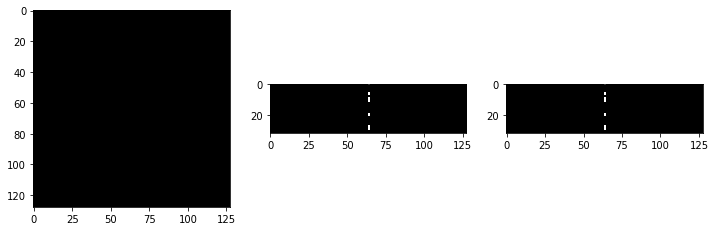

In [14]:
conditioning_data = data[0:32, 0:128, 0:128]
cond = np.zeros(conditioning_data.shape)
cond[:, 64, 64] = conditioning_data[:, 64, 64]
conditioning_data = cond.astype(np.int32)
fig, ax = plt.subplots(1, 3, figsize=(12, 12))
ax[0].imshow(conditioning_data[16, :, :], cmap="gray")
ax[1].imshow(conditioning_data[:, 64, :], cmap="gray")
ax[2].imshow(conditioning_data[:, :, 64], cmap="gray")

## Create Conditioned Images

We now instantiate the conditioner and provide a generator, discriminator, the conditioning data and a mask.
To condition on the log loss we will use Conditioner.condition_logloss().  

Our evaluation metric is the accuracy.

$$Accuracy = \frac{True \ Positives + True \ Negatives}{Positives + Negatives}$$

In [16]:
models = []
model_data = []
count = 0

#We only want to generate one conditioned realization here.
while count < 1:
    cond = Conditioner(3, generator, discriminator=discriminator, conditioning_data=conditioning_data, mask=mask, real_sample=real_sample, latent_size=latent_size, latent_dist="normal", verbose=True, use_cuda=True)
    steps, percep_np, content_np, total_np, zhat = cond.condition_logloss(1, [2, 4*2, 4*2], 100)
    x_cond = generator(zhat)
    x_hat_cond = np.where(x_cond.data.cpu().numpy()[0, 0]*0.5+0.5 >= 0.5, 1., 0)
    if accuracy_score(x_hat_cond[:, 64, 64].reshape(-1), conditioning_data[:, 64, 64].reshape(-1)) == 1.0:
        models.append(x_hat_cond)
        model_data.append([steps, percep_np, content_np, total_np, zhat.data.cpu().numpy()])
        count += 1

('Iteration: ', 0, ' Current accuracy: ', 0.5)
('Iteration: ', 1, ' Current accuracy: ', 0.5)
('Iteration: ', 2, ' Current accuracy: ', 0.75)
('Iteration: ', 3, ' Current accuracy: ', 0.75)
('Iteration: ', 4, ' Current accuracy: ', 0.8125)
('Iteration: ', 5, ' Current accuracy: ', 0.875)
('Iteration: ', 6, ' Current accuracy: ', 0.875)
('Iteration: ', 7, ' Current accuracy: ', 0.875)
('Iteration: ', 8, ' Current accuracy: ', 0.875)
('Iteration: ', 9, ' Current accuracy: ', 0.9375)
('Iteration: ', 10, ' Current accuracy: ', 0.96875)
('Iteration: ', 11, ' Current accuracy: ', 0.9375)
('Iteration: ', 12, ' Current accuracy: ', 0.9375)
('Iteration: ', 13, ' Current accuracy: ', 0.9375)
('Iteration: ', 14, ' Current accuracy: ', 0.96875)
('Iteration: ', 15, ' Current accuracy: ', 0.96875)
('Iteration: ', 16, ' Current accuracy: ', 0.96875)
('Iteration: ', 17, ' Current accuracy: ', 0.96875)
('Iteration: ', 18, ' Current accuracy: ', 0.96875)
('Iteration: ', 19, ' Current accuracy: ', 0.9687

## Evaluation of the generated models

We first look at the output after conditioning. This should look geologically realistic due to the perceptual loss constraints. We highlight the position of the conditioning well by the red line in the following graphs.

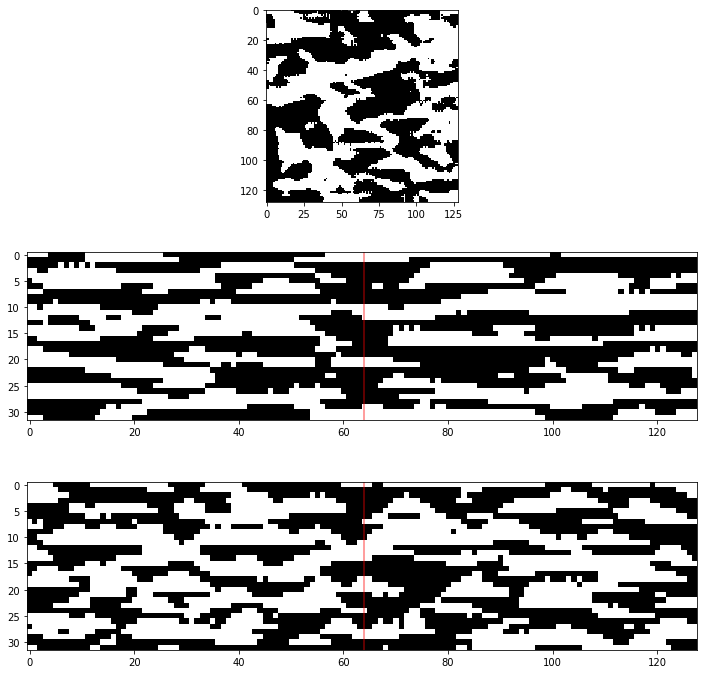

In [30]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
ax[0].imshow(models[0][16, :, :], cmap="gray", vmin=0.0, vmax=0.5)
ax[1].imshow(models[0][:, 32, :], cmap="gray", vmin=0.0, vmax=0.5)
ax[0].plot([64], [64], color="red")
ax[1].axvline(64, color="red", alpha=0.5)
ax[2].imshow(models[0][:, :, 32], cmap="gray", vmin=0.0, vmax=0.5)
ax[2].axvline(64, color="red", alpha=0.5)

We now evaluate the error of the model by subtracting the conditioned model and the conditionining data.  
This should result in a solid black line at the position of the well (center of graphs).  
And can be seen in the following graphs for this example.  

We also show the error at the well below.

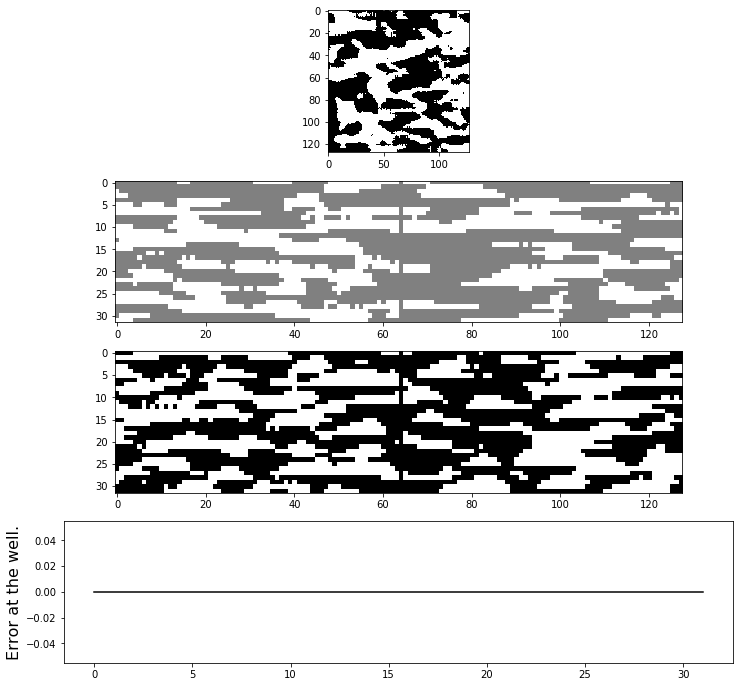

In [32]:
error = x_hat_cond-conditioning_data
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax[0].imshow(error[16, :, :], cmap="gray", vmin=0)
ax[1].imshow(error[:, 64,  :], cmap="gray", vmin=-1, vmax=1)
ax[2].imshow(error[:, :, 64], cmap="gray", vmin=0)
ax[3].plot(range(error[:, 64, 64].shape[0]), error[:, 64, 64], color="black")
ax[3].set_ylabel("Error at the well.", fontsize="16")

And finally we look at the output resulting facies distribution at the conditioned model well location and data.  
These should match exactly.

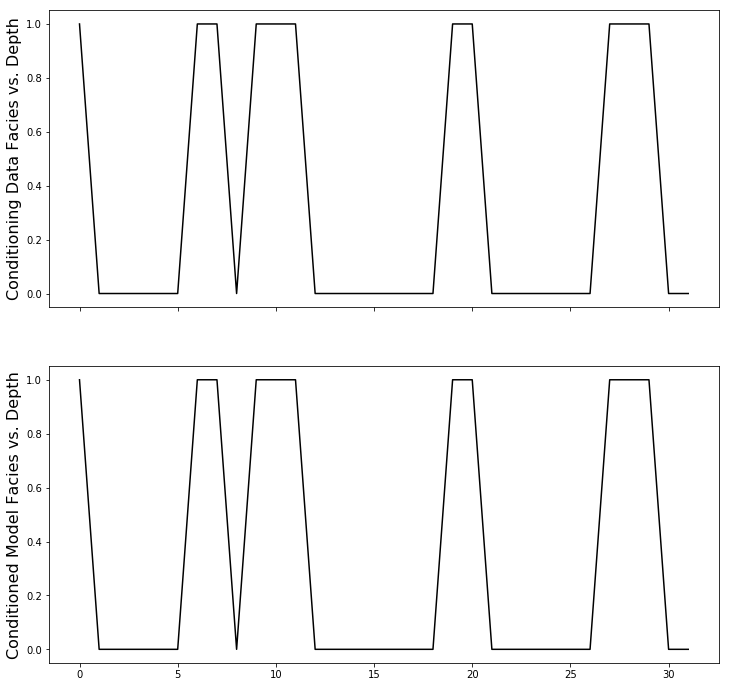

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
ax[0].plot(range(conditioning_data[:, 64, 64].shape[0]), conditioning_data[:, 64, 64], color="black")
ax[0].set_ylabel("Conditioning Data Facies vs. Depth", fontsize=16)
ax[1].plot(range(x_hat_cond[:, 64, 64].shape[0]), x_hat_cond[:, 64, 64], color="black")
ax[1].set_ylabel("Conditioned Model Facies vs. Depth", fontsize=16)